## **XGBoost** 
first step import dataset 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1️⃣ CARICAMENTO DATI
input_path = 'dataset/cleaned_train.csv'
df = pd.read_csv(input_path)

X = df.drop(columns='sii')  # Features
y = df['sii']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_matrix = xgb.DMatrix(X_train, label=y_train)
test_matrix = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': 4,  # 4 classi
    'seed': 42
}


ModuleNotFoundError: No module named 'xgboost'

## **Tuning Data**

L'ordine con cui si ottimizzano i parametri di un modello XGBoost è importante perché alcuni parametri hanno un impatto più significativo sugli altri. Ecco il motivo dietro la scelta di tunare i parametri in un ordine specifico:

#### **learning_rate e n_estimators**

- **learning_rate** (alias eta) controlla la velocità di apprendimento del modello. Un valore troppo alto può causare overfitting, mentre uno troppo basso può portare a una convergenza lenta.
- **n_estimators** definisce il numero di alberi nel modello. Se learning_rate è piccolo, serviranno più alberi per ottenere buone prestazioni. 

Troviamo un equilibrio tra learning_rate e il numero ottimale di alberi (n_estimators) usando early stopping per evitare overfitting.


In [ ]:
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
n_estimators = [50, 100, 200, 500]
best_lr, best_n_estimators = 0, 0
best_score = 0

for lr in learning_rates:
    for n in n_estimators:
        params['learning_rate'] = lr
        params['n_estimators'] = n
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'LR: {lr}, N_Est: {n}, Acc: {acc:.4f}')
        if acc > best_score:
            best_score = acc
            best_lr = lr
            best_n_estimators = n

params['learning_rate'] = best_lr
params['n_estimators'] = best_n_estimators
print(f'Best LR: {best_lr}, Best N_Estimators: {best_n_estimators}')



LR: 0.01, N_Est: 50, Acc: 0.6120
LR: 0.01, N_Est: 100, Acc: 0.5953
LR: 0.01, N_Est: 200, Acc: 0.5619
LR: 0.01, N_Est: 500, Acc: 0.5819
LR: 0.05, N_Est: 50, Acc: 0.5853
LR: 0.05, N_Est: 100, Acc: 0.5786
LR: 0.05, N_Est: 200, Acc: 0.5819
LR: 0.05, N_Est: 500, Acc: 0.5719
LR: 0.1, N_Est: 50, Acc: 0.5719
LR: 0.1, N_Est: 100, Acc: 0.5987
LR: 0.1, N_Est: 200, Acc: 0.5686
LR: 0.1, N_Est: 500, Acc: 0.5853
LR: 0.2, N_Est: 50, Acc: 0.5719
LR: 0.2, N_Est: 100, Acc: 0.5786
LR: 0.2, N_Est: 200, Acc: 0.5719
LR: 0.2, N_Est: 500, Acc: 0.5786
LR: 0.3, N_Est: 50, Acc: 0.5719
LR: 0.3, N_Est: 100, Acc: 0.5719
LR: 0.3, N_Est: 200, Acc: 0.5619
LR: 0.3, N_Est: 500, Acc: 0.5686
Best LR: 0.01, Best N_Estimators: 50


#### **max_depth e min_child_weight**

- **max_depth** controlla la profondità degli alberi. Alberi più profondi catturano meglio le informazioni, ma possono portare a overfitting.
- **min_child_weight** impone una soglia minima di peso per la suddivisione di un nodo. Valori più alti riducono la complessità del modello.

Troviamo il miglior compromesso tra complessità del modello e generalizzazione.

In [ ]:
max_depths = [3, 4, 5, 6]
min_child_weights = [1, 3, 5]
best_depth, best_child_weight = 0, 0
best_score = 0

for depth in max_depths:
    for child_weight in min_child_weights:
        params['max_depth'] = depth
        params['min_child_weight'] = child_weight
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'Depth: {depth}, Child Weight: {child_weight}, Acc: {acc:.4f}')
        if acc > best_score:
            best_score = acc
            best_depth = depth
            best_child_weight = child_weight

params['max_depth'] = best_depth
params['min_child_weight'] = best_child_weight
print(f'Best Depth: {best_depth}, Best Child Weight: {best_child_weight}')

Depth: 3, Child Weight: 1, Acc: 0.6388
Depth: 3, Child Weight: 3, Acc: 0.6388
Depth: 3, Child Weight: 5, Acc: 0.6388
Depth: 4, Child Weight: 1, Acc: 0.6221
Depth: 4, Child Weight: 3, Acc: 0.6388
Depth: 4, Child Weight: 5, Acc: 0.6355
Depth: 5, Child Weight: 1, Acc: 0.6120
Depth: 5, Child Weight: 3, Acc: 0.6388
Depth: 5, Child Weight: 5, Acc: 0.6355
Depth: 6, Child Weight: 1, Acc: 0.6120
Depth: 6, Child Weight: 3, Acc: 0.6254
Depth: 6, Child Weight: 5, Acc: 0.6187
Best Depth: 3, Best Child Weight: 1


#### **gamma**

gamma imposta un costo minimo per la suddivisione di un nodo. Se impostato troppo basso, il modello sarà troppo complesso. Aiutiamo il modello a decidere quando vale la pena suddividere un nodo per evitare overfitting.

In [ ]:
gamma_values = [0,0.01,0.05, 0.1, 0.2, 0.3, 0.4]
best_gamma = 0
best_score = 0

for gamma in gamma_values:
    params['gamma'] = gamma
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'Gamma: {gamma}, Acc: {acc:.4f}')
    if acc > best_score:
        best_score = acc
        best_gamma = gamma

params['gamma'] = best_gamma
print(f'Best Gamma: {best_gamma}')

Gamma: 0, Acc: 0.6388
Gamma: 0.01, Acc: 0.6388
Gamma: 0.05, Acc: 0.6388
Gamma: 0.1, Acc: 0.6388
Gamma: 0.2, Acc: 0.6388
Gamma: 0.3, Acc: 0.6388
Gamma: 0.4, Acc: 0.6355
Best Gamma: 0


#### **subsample e colsample_bytree**

- **subsample** specifica la frazione di dati usata per costruire ogni albero. Se è troppo alto, c'è rischio di overfitting.
- **colsample_bytree** seleziona una frazione di feature per ogni albero, riducendo la correlazione tra alberi e migliorando la generalizzazione.

Evitiamo overfitting riducendo la dipendenza tra gli alberi nel modello.



In [ ]:
subsamples = [0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colsample_bytrees = [0.1, 0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_subsample, best_colsample = 0, 0
best_score = 0

for subsample in subsamples:
    for colsample in colsample_bytrees:
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'Subsample: {subsample}, Colsample: {colsample}, Acc: {acc:.4f}')
        if acc > best_score:
            best_score = acc
            best_subsample = subsample
            best_colsample = colsample

params['subsample'] = best_subsample
params['colsample_bytree'] = best_colsample
print(f'Best Subsample: {best_subsample}, Best Colsample: {best_colsample}')


Subsample: 0.1, Colsample: 0.1, Acc: 0.6087
Subsample: 0.1, Colsample: 0.2, Acc: 0.6087
Subsample: 0.1, Colsample: 0.3, Acc: 0.6154
Subsample: 0.1, Colsample: 0.4, Acc: 0.6154
Subsample: 0.1, Colsample: 0.5, Acc: 0.6254
Subsample: 0.1, Colsample: 0.6, Acc: 0.6221
Subsample: 0.1, Colsample: 0.7, Acc: 0.6187
Subsample: 0.1, Colsample: 0.8, Acc: 0.6321
Subsample: 0.1, Colsample: 0.9, Acc: 0.6388
Subsample: 0.1, Colsample: 1.0, Acc: 0.6254
Subsample: 0.2, Colsample: 0.1, Acc: 0.6087
Subsample: 0.2, Colsample: 0.2, Acc: 0.6087
Subsample: 0.2, Colsample: 0.3, Acc: 0.6154
Subsample: 0.2, Colsample: 0.4, Acc: 0.6087
Subsample: 0.2, Colsample: 0.5, Acc: 0.6288
Subsample: 0.2, Colsample: 0.6, Acc: 0.6254
Subsample: 0.2, Colsample: 0.7, Acc: 0.6254
Subsample: 0.2, Colsample: 0.8, Acc: 0.6321
Subsample: 0.2, Colsample: 0.9, Acc: 0.6388
Subsample: 0.2, Colsample: 1.0, Acc: 0.6455
Subsample: 0.3, Colsample: 0.1, Acc: 0.6087
Subsample: 0.3, Colsample: 0.2, Acc: 0.6087
Subsample: 0.3, Colsample: 0.3, 

## **Valutazione del modello**

#### **Accuracy e LogLoss**

- **Accuracy** valuta solo il numero di previsioni corrette
- **logloss** penalizza più severamente gli errori fatti con alta certezza, fornendo una visione più dettagliata della qualità delle previsioni probabilistiche.

In [ ]:
from sklearn.metrics import confusion_matrix, log_loss

model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')
y_pred_proba = model.predict_proba(X_test)  # Probabilità per ogni classe
logloss = log_loss(y_test, y_pred_proba)
print(f'Log Loss: {logloss:.4f}')


[0]	validation_0-mlogloss:1.37899	validation_1-mlogloss:1.37998


[1]	validation_0-mlogloss:1.37166	validation_1-mlogloss:1.37300
[2]	validation_0-mlogloss:1.36513	validation_1-mlogloss:1.36673
[3]	validation_0-mlogloss:1.35789	validation_1-mlogloss:1.36016
[4]	validation_0-mlogloss:1.35063	validation_1-mlogloss:1.35316
[5]	validation_0-mlogloss:1.34381	validation_1-mlogloss:1.34677
[6]	validation_0-mlogloss:1.33753	validation_1-mlogloss:1.34109
[7]	validation_0-mlogloss:1.33108	validation_1-mlogloss:1.33546
[8]	validation_0-mlogloss:1.32499	validation_1-mlogloss:1.32950
[9]	validation_0-mlogloss:1.31826	validation_1-mlogloss:1.32340
[10]	validation_0-mlogloss:1.31214	validation_1-mlogloss:1.31788
[11]	validation_0-mlogloss:1.30600	validation_1-mlogloss:1.31182
[12]	validation_0-mlogloss:1.30070	validation_1-mlogloss:1.30668
[13]	validation_0-mlogloss:1.29448	validation_1-mlogloss:1.30140
[14]	validation_0-mlogloss:1.28889	validation_1-mlogloss:1.29595
[15]	validation_0-mlogloss:1.28282	validation_1-mlogloss:1.29032
[16]	validation_0-mlogloss:1.27722

#### **Grafico Logloss**

Il codice visualizza l'andamento della log loss per il training e il validation set durante l'addestramento di un modello XGBoost, mostrando come evolve la performance del modello nel tempo.

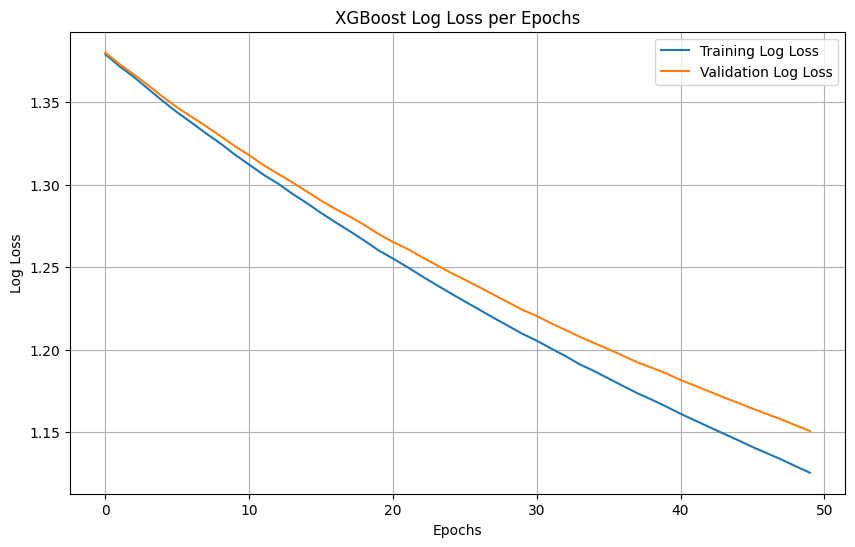

In [ ]:
# Assumiamo che results contenga i risultati ottenuti da model.evals_result()
results = model.evals_result()

# Estrai i valori di logloss per il training e il validation set (modifica se hai altre metriche)
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Grafico dell'andamento della logloss per il training e il validation set
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Training Log Loss')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation Log Loss')

plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss per Epochs')
plt.legend()
plt.grid(True)
plt.show()

#### **Confusion Matrix**

Il codice genera e visualizza una matrice di confusione utilizzando una heatmap, confrontando le etichette vere (y_test) con le etichette predette (y_pred). Le celle della matrice mostrano il numero di occorrenze per ogni combinazione di etichetta vera e predetta, con colori che rappresentano la frequenza.

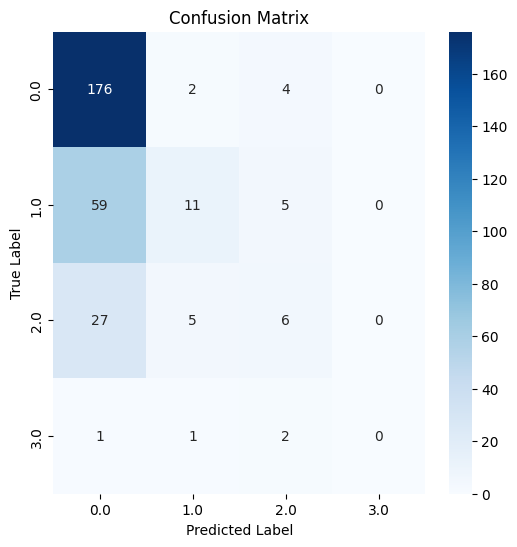

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### **Features Importance**

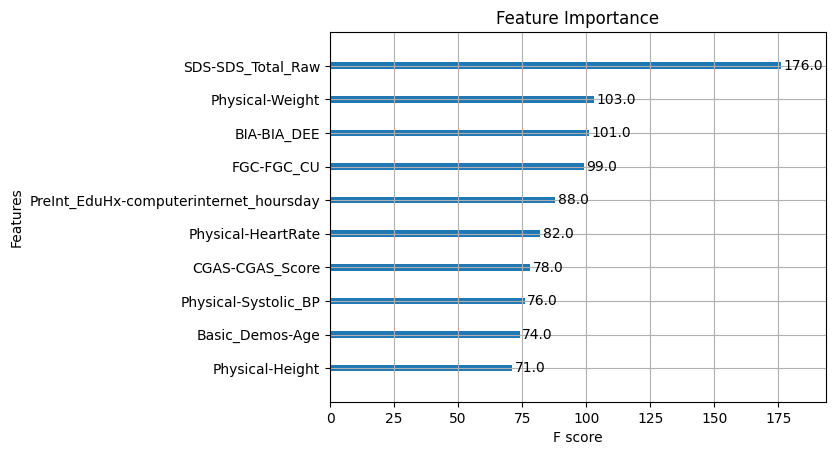

In [ ]:
xgb.plot_importance(model, importance_type="weight", max_num_features=10, title="Feature Importance")
plt.show()


## **Cross Validation**

GridSearchCV è una tecnica per ottimizzare gli iperparametri di un modello testando sistematicamente diverse combinazioni e selezionando quella con le migliori prestazioni su dati di validazione. Usa la cross-validation per ridurre il rischio di overfitting, ma può anche abbassare l'accuratezza o aumentare la log loss se il modello diventa troppo complesso o si adatta troppo ai dati di training.

In [ ]:
from xgboost import XGBClassifier


xgb_cv = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')

# Definizione della grid per il tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'gamma': [0],
    'subsample': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.1, 0.5, 1.0] 
}

# Grid search per il tuning di tutti i parametri
grid = GridSearchCV(xgb_cv, param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

# Parametri migliori
best_params = grid.best_params_

# Addestramento del modello con i migliori parametri
final_model = XGBClassifier(**best_params, n_jobs=-1)
final_model.fit(X_train, y_train)

# Valutazione del modello
predictions = final_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy finale del modello: {accuracy:.4f}')

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.1; total ti

/Users/leo/Desktop/universita/basi_progetto/DB_project/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Accuracy finale del modello: 0.6321


[0]	validation_0-mlogloss:1.37887	validation_1-mlogloss:1.37954
[1]	validation_0-mlogloss:1.37129	validation_1-mlogloss:1.37226
[2]	validation_0-mlogloss:1.36422	validation_1-mlogloss:1.36589
[3]	validation_0-mlogloss:1.35686	validation_1-mlogloss:1.35942
[4]	validation_0-mlogloss:1.34959	validation_1-mlogloss:1.35297
[5]	validation_0-mlogloss:1.34235	validation_1-mlogloss:1.34632
[6]	validation_0-mlogloss:1.33543	validation_1-mlogloss:1.34006
[7]	validation_0-mlogloss:1.32872	validation_1-mlogloss:1.33401
[8]	validation_0-mlogloss:1.32192	validation_1-mlogloss:1.32808
[9]	validation_0-mlogloss:1.31546	validation_1-mlogloss:1.32194
[10]	validation_0-mlogloss:1.30901	validation_1-mlogloss:1.31605
[11]	validation_0-mlogloss:1.30247	validation_1-mlogloss:1.31014
[12]	validation_0-mlogloss:1.29621	validation_1-mlogloss:1.30448
[13]	validation_0-mlogloss:1.29008	validation_1-mlogloss:1.29900
[14]	validation_0-mlogloss:1.28422	validation_1-mlogloss:1.29382
[15]	validation_0-mlogloss:1.27822	

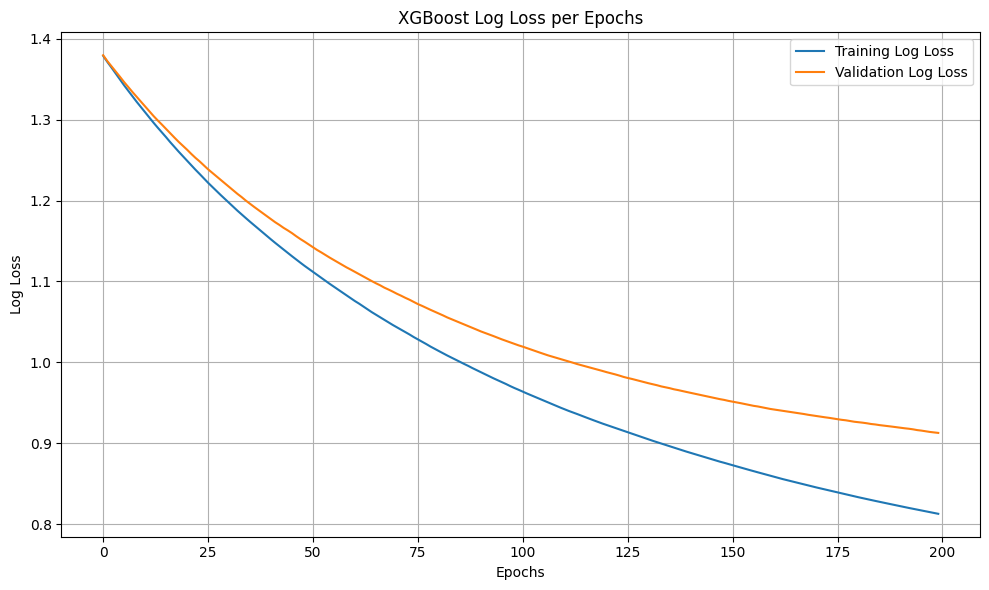

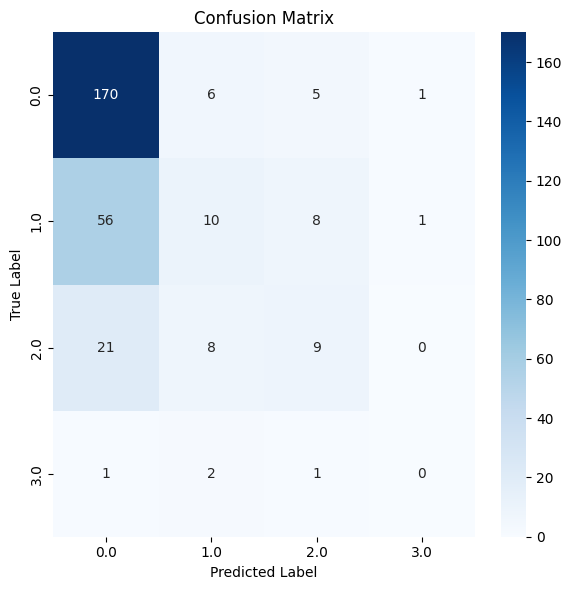

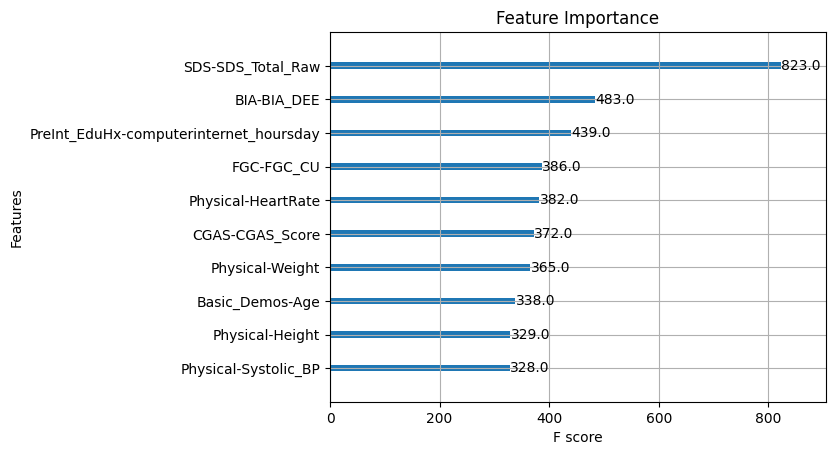

In [ ]:
final_model = xgb.XGBClassifier(**best_params)

final_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

# Predizioni
y_pred = final_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')

# Probabilità di previsione per il calcolo della log loss
y_pred_proba = final_model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
print(f'Log Loss: {logloss:.4f}')

# 🔹 3. FEATURE IMPORTANCE
# Otteniamo i risultati dell'addestramento
results = final_model.evals_result()

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(epochs)

    # Grafico dell'andamento della log loss
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Training Log Loss')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation Log Loss')

plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss per Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

xgb.plot_importance(final_model, importance_type="weight", max_num_features=10, title="Feature Importance")
plt.show()